In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
import hist
import pandas as pd
import uproot
import json
import matplotlib.pyplot as plt

In [2]:
kfactors = uproot.open("https://github.com/nsmith-/coffeandbacon/raw/master/analysis/correction_files/kfactors.root")
kfactors2 = uproot.open("https://github.com/nsmith-/coffeandbacon/raw/master/analysis/correction_files/ZJets_QCD_NLO.root")
kfactors3 = uproot.open("https://github.com/nsmith-/coffeandbacon/raw/master/analysis/correction_files/WJets_QCD_NLO.root")


In [3]:
" ".join(kfactors)

'ZJets_01j_NLO;1 ZJets_01j_NLO/nominal;1 ZJets_01j_NLO/fact_up;1 ZJets_01j_NLO/fact_down;1 ZJets_01j_NLO/ren_up;1 ZJets_01j_NLO/ren_down;1 ZJets_01j_NLO/PDF;1 ZJets_012j_NLO;1 ZJets_012j_NLO/nominal;1 ZJets_012j_NLO/fact_up;1 ZJets_012j_NLO/fact_down;1 ZJets_012j_NLO/ren_up;1 ZJets_012j_NLO/ren_down;1 ZJets_012j_NLO/PDF;1 WJets_012j_NLO;1 WJets_012j_NLO/nominal;1 WJets_012j_NLO/fact_up;1 WJets_012j_NLO/fact_down;1 WJets_012j_NLO/ren_up;1 WJets_012j_NLO/ren_down;1 WJets_012j_NLO/PDF;1 GJets_1j_NLO;1 GJets_1j_NLO/nominal_G;1 GJets_1j_NLO/fact_up_G;1 GJets_1j_NLO/fact_down_G;1 GJets_1j_NLO/ren_up_G;1 GJets_1j_NLO/ren_down_G;1 GJets_1j_NLO/PDF;1 ZJets_LO;1 ZJets_LO/inv_pt;1 GJets_LO;1 GJets_LO/inv_pt_G;1 WJets_LO;1 WJets_LO/inv_pt;1 EWKcorr;1 EWKcorr/Z;1 EWKcorr/photon;1 EWKcorr/W;1'

In [4]:
kfactors2["Z_NLO_QCD_2017"].to_hist()

Hist(Regular(25, 0, 1000, name='xaxis', label='xaxis'), storage=Weight()) # Sum: WeightedSum(value=30.6146, variance=0.0257869) (WeightedSum(value=31.2787, variance=0.0272645) with flow)

In [5]:
kfactors["EWKcorr/Z;1"].to_hist()

Hist(Variable(array([ 150.,  170.,  200.,  230.,  260.,  290.,  320.,  350.,  390.,
        430.,  470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,
        840.,  900.,  960., 1020., 1090., 1160., 1250.]), name='xaxis', label='xaxis'), storage=Weight()) # Sum: WeightedSum(value=1.51303, variance=0.000287354) (WeightedSum(value=1.51304, variance=0.000287354) with flow)

In [6]:
def blocks(lines):
    lines = iter(lines)
    tag, block = "", []
    try:
        while True:
            line = next(lines)
            begintag = "# BEGIN "
            if line.startswith(begintag):
                tag = line[len(begintag):]
                block = []
            elif line.startswith("# END "):
                yield tag, block
            elif len(line):
                block.append(line)
    except StopIteration:
        pass


def tohist(block):
    assert block[0] == '# xlow   xhigh   val   errminus  errplus'
    data = np.fromstring(" ".join(block[1:]), sep=" ").reshape(-1, 5)
    assert np.all(data[1:, 0] == data[:-1, 1])
    edges = np.concatenate([data[:, 0], data[-1:, 1]])
    val, lo, hi = data[:, 2:].T
    h = hist.Hist.new.Var(edges).Weight()
    h.view().value = val
    h.view().variance = (hi - lo)**2 / 4
    return h


def load_yoda(lines):
    hists = {}
    data = {}
    for tag, block in blocks(lines.split("\n")):
        if tag.startswith("HISTO1D"):
            hists[tag[8:]] = tohist(block)
        elif tag.startswith("DATA"):
            for l in block:
                k, v = l.split("=")
                data[k] = v
    return data, hists

In [7]:
import requests

eejmeta, eej = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/eej.dat").text)
vvjmeta, vvj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/vvj.dat").text)
evjmeta, evj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/evj.dat").text)
lindert = dict(**eej, **vvj, **evj)

In [8]:
def make_lindert_pred(process, order):
    """Eqn. 76 of https://arxiv.org/pdf/1705.04664.pdf
    
    process: eej, evj, vvj; order: NLO, NNLO
    """
    sigma_lo = lindert[f"{process}_pTV_LO"].values()
    kqcd = lindert[f"{process}_pTV_K_{order}"].values()
    deltas = np.empty((3 + 106, len(kqcd)))
    kewk = lindert[f"{process}_pTV_kappa_EW"].values()
    deltas_ew = np.empty((3, len(kqcd)))
    delta_mix = lindert[f"{process}_pTV_dK_{order}_mix"].values()[None, :]

    for i in range(3):
        deltas[i, :] = lindert[f"{process}_pTV_d{i + 1}K_{order}"].values()

    for i in range(106):
        deltas[i + 3, :] = lindert[f"{process}_pTV_dK_PDF_{i + 1}"].values()

    for i in range(3):
        deltas_ew[i, :] = lindert[f"{process}_pTV_d{i + 1}kappa_EW"].values()

    def pred(epsilon, ew=True):
        """epsilon: (*, 3 + 106 + 3 + 1) (qcd scale, pdf, ewk variation, cross-term)"""
        Kth = (kqcd + epsilon[..., :109] @ deltas)
        if ew:
            Kth *= (1 + kewk + epsilon[..., 109:112] @ deltas_ew)
            Kth += epsilon[..., 112:113] @ delta_mix
        return Kth * sigma_lo
    
    return pred

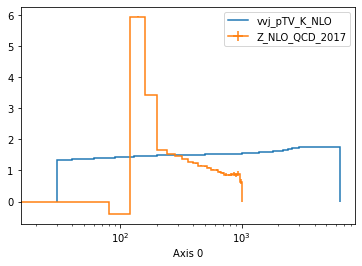

In [9]:
fig, ax = plt.subplots()

lindert["vvj_pTV_K_NLO"].plot(ax=ax, yerr=False, label="vvj_pTV_K_NLO")
kfactors2["Z_NLO_QCD_2017"].to_hist().plot(ax=ax, label="Z_NLO_QCD_2017")
ax.set_xscale("log")
ax.legend()

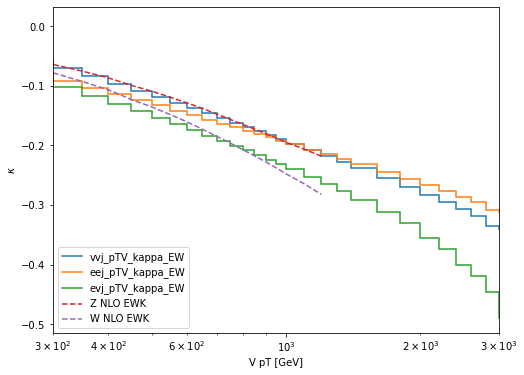

In [10]:
from scipy.interpolate import interp1d

def hinterp(h):
    ax = h.axes[0]
    return interp1d(ax.centers, h.view().value, bounds_error=False)

fig, ax = plt.subplots(figsize=(8, 6))

lindert["vvj_pTV_kappa_EW"].plot(ax=ax, label="vvj_pTV_kappa_EW", yerr=False)
lindert["eej_pTV_kappa_EW"].plot(ax=ax, label="eej_pTV_kappa_EW", yerr=False)
lindert["evj_pTV_kappa_EW"].plot(ax=ax, label="evj_pTV_kappa_EW", yerr=False)


ourn = hinterp(kfactors["EWKcorr/Z;1"].to_hist())
ourd = hinterp(kfactors['ZJets_012j_NLO/nominal'].to_hist())
wpedges = lindert["vvj_pTV_kappa_EW"].axes[0].edges
ax.plot(wpedges, ourn(wpedges) / ourd(wpedges) - 1, label="Z NLO EWK", linestyle="--")

ourn = hinterp(kfactors["EWKcorr/W;1"].to_hist())
ourd = hinterp(kfactors['WJets_012j_NLO/nominal'].to_hist())
ax.plot(wpedges, ourn(wpedges) / ourd(wpedges) - 1, label="W NLO EWK", linestyle="--")

ax.set_xscale("log")
ax.set_xlabel("V pT [GeV]")
ax.set_xlim(300, 3000)
ax.set_ylabel("$\kappa$")
ax.legend()
plt.savefig("V_kappaEW.pdf")

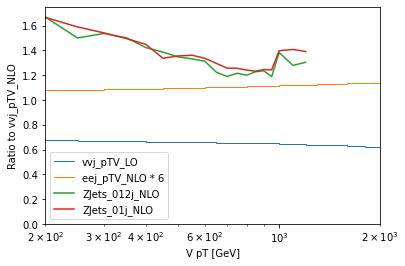

In [11]:
fig, ax = plt.subplots()

den = lindert["vvj_pTV_NLO"].values()
wpedges = lindert["vvj_pTV_NLO"].axes[0].edges

ax.stairs(lindert["vvj_pTV_LO"].values() / den, wpedges, label="vvj_pTV_LO")
ax.stairs(lindert["eej_pTV_NLO"].values() * 6 / den, wpedges, label="eej_pTV_NLO * 6")

ax.plot(wpedges[:-1], hinterp(kfactors['ZJets_012j_NLO/nominal'].to_hist())(wpedges[:-1]) / den, label="ZJets_012j_NLO")
ax.plot(wpedges[:-1], hinterp(kfactors['ZJets_01j_NLO/nominal'].to_hist())(wpedges[:-1]) / den, label="ZJets_01j_NLO")

ax.set_xscale("log")
ax.set_xlim(200, 2000)
ax.set_ylabel("Ratio to vvj_pTV_NLO")
ax.set_xlabel("V pT [GeV]")
ax.legend()

In [12]:
with open("../nanocc/metadata/v2x17_lpc_merged.json") as fin:
    fileset = json.load(fin)

import glob
for dsf in glob.glob("ds/*"):
    ds = dsf.split("/")[1]
    with open(dsf) as fin:
        fileset[ds] = ["root://cmsxrootd.fnal.gov/" + fn.strip() for fn in fin]

xs = {
    # MLM ll (to see if a* and offshell matter)
    # "DYJetsToLL_M-50_HT-200to400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 40.99,
    "DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8": 6.968,
    "DYJetsToLL_M-50_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8": 1.743,
    "DYJetsToLL_M-50_HT-800to1200_TuneCP5_13TeV-madgraphMLM-pythia8": 0.8052,
    "DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-madgraphMLM-pythia8": 0.1933, 
    "DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madgraphMLM-pythia8": 0.003468,
    # ours
    "WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 314.90,
    "WJetsToQQ_HT600to800_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 68.64,
    "WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 34.70,
    "ZJetsToQQ_HT400to600_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 144.70,
    "ZJetsToQQ_HT600to800_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 34.06,
    "ZJetsToQQ_HT-800toInf_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 18.57,
    # monoJet NLO
    "DY1JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 1.097,
    "DY1JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.1207,
    "DY2JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 2.74,
    "DY2JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.4492,
    "W1JetsToLNu_LHEWpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 8.06,
    "W1JetsToLNu_LHEWpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.89,
    "W2JetsToLNu_LHEWpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 18.03,
    "W2JetsToLNu_LHEWpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 3,
    "Z1JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 2.051,
    "Z1JetsToNuNu_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.2251,
    "Z2JetsToNuNU_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.8472,
    "Z2JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 5.174,
    # a different 012j pt-binned
    # https://github.com/cms-sw/genproductions/tree/master/bin/MadGraph5_aMCatNLO/cards/production/2017/13TeV/DYJets_updated_ptbin_NLO/Zpt_250To400
    "DYJetsToLL_Pt-250To400_TuneCP5_13TeV-amcatnloFXFX-pythia8": 3.774,
    "DYJetsToLL_Pt-400To650_TuneCP5_13TeV-amcatnloFXFX-pythia8": 0.5164,
    "DYJetsToLL_Pt-650ToInf_TuneCP5_13TeV-amcatnloFXFX-pythia8": 0.04796,
}
fileset = {ds: fileset[ds] for ds in xs}

In [13]:
with open("../nanocc/metadata/v2x16_lpc_merged.json") as fin:
    fileset16 = json.load(fin)

xs16 = {
    "WJetsToQQ_HT-800toInf_qc19_3j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 30.17,
    "WJetsToQQ_HT400to600_qc19_3j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 269.90,
    "WJetsToQQ_HT600to800_qc19_3j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 59.52,
    "ZJetsToQQ_HT-800toInf_qc19_4j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 15.01,
    "ZJetsToQQ_HT400to600_qc19_4j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 116.70,
    "ZJetsToQQ_HT600to800_qc19_4j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8": 27.37,
}
fileset16 = {ds: fileset16[ds] for ds in xs16}

xs.update(xs16)
fileset.update(fileset16)

In [14]:
import warnings
warnings.filterwarnings("ignore", "Found duplicate branch")

ds = "Z2JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8"
fn = fileset[ds][0]
events = NanoEventsFactory.from_root(fn, metadata={"dataset": ds}, entry_stop=100000).events()

In [14]:
from coffea import processor

class VPtProc(processor.ProcessorABC):
    edges = np.array([  30.,   40.,   50.,   60.,   70.,   80.,   90.,  100.,  110.,
        120.,  130.,  140.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1100., 1200., 1300., 1400., 1600., 1800.,
       2000., 2200., 2400., 2600., 2800., 3000., 6500.])

    def process(self, events):
        boson = ak.firsts(events.GenPart[
            ((events.GenPart.pdgId == 23)|(abs(events.GenPart.pdgId) == 24))
            & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
        ])
        vpt = ak.fill_none(boson.pt, 0.)
        offshell = events.GenPart[
            events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
            & ak.is_none(boson)
            & (abs(events.GenPart.pdgId) >= 11) & (abs(events.GenPart.pdgId) <= 16)
        ].sum()
        scalevar = (
            hist.Hist.new
            .IntCat(range(8))
            .Var(self.edges).Weight()
        )
        for i in range(8):
            scalevar.fill(i, vpt + offshell.pt, weight=events.genWeight * events.LHEScaleWeight[:, i])

        return {
            events.metadata["dataset"]: {
                "Vpt_resonant": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(vpt, weight=events.genWeight)
                ),
                "Vpt_nano": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(events.LHE.Vpt, weight=events.genWeight)
                ),
                "Vpt": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(vpt + offshell.pt, weight=events.genWeight)
                ),
                "Vptscale": scalevar,
                "Vmass": (
                    hist.Hist.new
                    .StrCat(["V", "offshell"])
                    .Reg(105, 30, 240, name="mass")
                    .Weight()
                    .fill("V", ak.fill_none(boson.mass, 0.), weight=events.genWeight)
                    .fill("offshell", offshell.mass, weight=events.genWeight)
                ),
                "sumw": ak.sum(events.genWeight),
            }
        }

    def postprocess(self, x):
        return x
    
vptproc = VPtProc()

In [ ]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster


cluster = LPCCondorCluster()
cluster.adapt(minimum=0, maximum=200)
client = Client(cluster)

In [ ]:
from dask.distributed import performance_report
import datetime
import json
import coffea.util


now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with performance_report(filename=f"daskreport_{now}.html"):
    res, stats = processor.run_uproot_job(
        fileset16, "Events", vptproc, processor.dask_executor,
        {
            "client": client,
            "schema": processor.NanoAODSchema,
            "savemetrics": True,
            "skipbadfiles": True,
        },
    )
    

def serialize_sets(obj):
    if isinstance(obj, set):
        return list(obj)

    return obj

with open(f"stats_{now}.json", "w") as fout:
    json.dump(stats, fout, indent=4, default=serialize_sets)
    

coffea.util.save(res, f"run_{now}.coffea")

In [118]:
client.restart()
cluster.scale(0)
client = None
cluster = None

In [15]:
import coffea.util
res = processor.accumulate([
    # 2017 samples
    coffea.util.load("run_20210423_132139.coffea"),
    # 2016 samples
    coffea.util.load("run_20210428_131703.coffea"),
])

In [16]:
scaled = {}
for ds, plots in res.items():
    xsw = xs[ds] / plots["sumw"]
    lum = plots["Vpt_nano"].sum(flow=True)
    sds = {
        "samples": {(ds, xs[ds], lum.value**2 / lum.variance / xs[ds] / 1000)}
    }
    for name, h in plots.items():
        if isinstance(h, hist.Hist):
            h = h.copy()
            h.view().value *= xsw
            h.view().variance *= xsw**2
            if "Vpt" in name:
                h.view().value /= h.axes[-1].widths
                h.view().variance /= h.axes[-1].widths**2
            sds[name] = h
    scaled[ds] = sds

In [17]:
cms_vvj = processor.accumulate([v for k, v in scaled.items() if "JetsToNu" in k])
cms_llj = processor.accumulate([v for k, v in scaled.items() if "DY1JetsToLL" in k or "DY2JetsToLL" in k])
cms_lljj = processor.accumulate([v for k, v in scaled.items() if "DY2JetsToLL" in k])
cms_llj_other = processor.accumulate([v for k, v in scaled.items() if "DYJetsToLL" in k and "FXFX" in k])
cms_llj_mlm = processor.accumulate([v for k, v in scaled.items() if "JetsToLL" in k and "MLM" in k])
cms_zqqj_mlm = processor.accumulate([v for k, v in scaled.items() if "ZJetsToQQ" in k and "MLM" in k and "TuneCP5" in k])
cms_zqqj_mlm16 = processor.accumulate([v for k, v in scaled.items() if "ZJetsToQQ" in k and "MLM" in k and "TuneCUETP8M1" in k])
cms_lvj = processor.accumulate([v for k, v in scaled.items() if "ToLNu" in k])
cms_wqqj_mlm = processor.accumulate([v for k, v in scaled.items() if "WJetsToQQ" in k and "TuneCP5" in k])
cms_wqqj_mlm16 = processor.accumulate([v for k, v in scaled.items() if "WJetsToQQ" in k and "TuneCUETP8M1" in k])

In [18]:
df = pd.DataFrame(
    sorted(("CMS Z(vv)+2j NLO",) + tup for tup in cms_vvj["samples"])
    + sorted(("CMS Z(ll)+2j NLO",) + tup for tup in cms_llj["samples"])
    + sorted(("CMS Z(ll)+4j MLM",) + tup for tup in cms_llj_mlm["samples"])
    + sorted(("CMS Z(qq)+4j MLM",) + tup for tup in cms_zqqj_mlm["samples"])
    + sorted(("CMS Z(qq)+4j MLM (2016)",) + tup for tup in cms_zqqj_mlm16["samples"])
    + sorted(("CMS W(lv)+2j NLO",) + tup  for tup in cms_lvj["samples"])
    + sorted(("CMS W(qq)+2j MLM",) + tup  for tup in cms_wqqj_mlm["samples"])
    + sorted(("CMS W(qq)+2j MLM (2016)",) + tup  for tup in cms_wqqj_mlm16["samples"]),
    columns=["Sample", "PD component", "$\sigma$ [pb]", "Effective lumi [1/fb]"]
)
#print(df.set_index(["Sample", "PD component"]).to_latex())
df.set_index(["Sample", "PD component"])

$\sigma$ [pb]  \
Sample                  PD component                                                        
CMS Z(vv)+2j NLO        Z1JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-...       2.051000   
                        Z1JetsToNuNu_M-50_LHEZpT_400-inf_TuneCP5_13TeV-...       0.225100   
                        Z2JetsToNuNU_M-50_LHEZpT_400-inf_TuneCP5_13TeV-...       0.847200   
                        Z2JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-...       5.174000   
CMS Z(ll)+2j NLO        DY1JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-a...       1.097000   
                        DY1JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-a...       0.120700   
                        DY2JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-a...       2.740000   
                        DY2JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-a...       0.449200   
CMS Z(ll)+4j MLM        DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-mad...       0.193300   
                        DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madg...       0.003468   
                        DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgr...       6.968000   
                        DYJetsToLL_M-50_HT-600to800_TuneCP5_13TeV-madgr...       1.743000   
                        DYJetsToLL_M-50_HT-800to1200_TuneCP5_13TeV-madg...       0.805200   
CMS Z(qq)+4j MLM        ZJetsToQQ_HT-800toInf_qc19_4j_TuneCP5_13TeV-mad...      18.570000   
                        ZJetsToQQ_HT400to600_qc19_4j_TuneCP5_13TeV-madg...     144.700000   
                        ZJetsToQQ_HT600to800_qc19_4j_TuneCP5_13TeV-madg...      34.060000   
CMS Z(qq)+4j MLM (2016) ZJetsToQQ_HT-800toInf_qc19_4j_TuneCUETP8M1_13Te...      15.010000   
                        ZJetsToQQ_HT400to600_qc19_4j_TuneCUETP8M1_13TeV...     116.700000   
                        ZJetsToQQ_HT600to800_qc19_4j_TuneCUETP8M1_13TeV...      27.370000   
CMS W(lv)+2j NLO        W1JetsToLNu_LHEWpT_250-400_TuneCP5_13TeV-amcnlo...       8.060000   
                        W1JetsToLNu_LHEWpT_400-inf_TuneCP5_13TeV-amcnlo...       0.890000   
                        W2JetsToLNu_LHEWpT_250-400_TuneCP5_13TeV-amcnlo...      18.030000   
                        W2JetsToLNu_LHEWpT_400-inf_TuneCP5_13TeV-amcnlo...       3.000000   
CMS W(qq)+2j MLM        WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-mad...      34.700000   
                        WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV-madg...     314.900000   
                        WJetsToQQ_HT600to800_qc19_3j_TuneCP5_13TeV-madg...      68.640000   
CMS W(qq)+2j MLM (2016) WJetsToQQ_HT-800toInf_qc19_3j_TuneCUETP8M1_13Te...      30.170000   
                        WJetsToQQ_HT400to600_qc19_3j_TuneCUETP8M1_13TeV...     269.900000   
                        WJetsToQQ_HT600to800_qc19_3j_TuneCUETP8M1_13TeV...      59.520000   

                                                                            Effective lumi [1/fb]  
Sample                  PD component                                                               
CMS Z(vv)+2j NLO        Z1JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-...            3725.000544  
                        Z1JetsToNuNu_M-50_LHEZpT_400-inf_TuneCP5_13TeV-...            4960.065985  
                        Z2JetsToNuNU_M-50_LHEZpT_400-inf_TuneCP5_13TeV-...            4099.687825  
                        Z2JetsToNuNu_M-50_LHEZpT_250-400_TuneCP5_13TeV-...            2017.178779  
CMS Z(ll)+2j NLO        DY1JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-a...            3619.389780  
                        DY1JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-a...            7351.184101  
                        DY2JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-a...            2690.966030  
                        DY2JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-a...            3973.773353  
CMS Z(ll)+4j MLM        DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-mad...            3147.682738  
                        DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madg...          110764.2

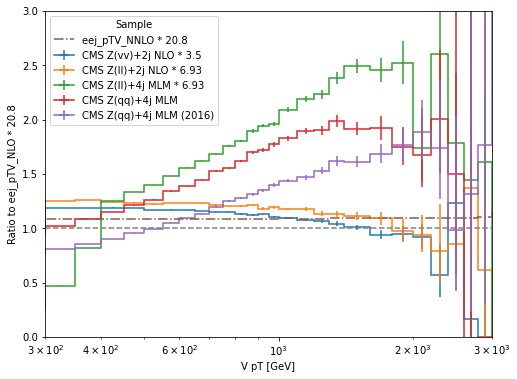

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

name = "Vpt"
den = lindert["eej_pTV_NLO"].values() * 20.8
ax.axhline(1, color="grey", linestyle="--")

def scale(h, s):
    h = h.copy()
    h.view().value *= s
    h.view().variance *= s**2
    return h

scale(cms_vvj[name], 3.5 / den).plot1d(ax=ax, label="CMS Z(vv)+2j NLO * 3.5")
scale(cms_llj[name], 6.93 / den).plot1d(label="CMS Z(ll)+2j NLO * 6.93")
# scale(cms_llj_other[name], 6.93 / den).plot1d(label="CMS Z(ll)+2j NLO' * 6.93")
scale(cms_llj_mlm[name], 6.93 / den).plot1d(label="CMS Z(ll)+4j MLM * 6.93")
scale(cms_zqqj_mlm[name], 1 / den).plot1d(label="CMS Z(qq)+4j MLM")
scale(cms_zqqj_mlm16[name], 1 / den).plot1d(label="CMS Z(qq)+4j MLM (2016)")
scale(lindert["eej_pTV_NNLO"], 20.8 / den).plot1d(yerr=False, linestyle="-.", label="eej_pTV_NNLO * 20.8")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 3.)
ax.set_ylabel("Ratio to eej_pTV_NLO * 20.8")
ax.set_xlabel("V pT [GeV]")
ax.legend(title="Sample", loc="upper left")
fig.savefig("ZqqPt_vs_lindertNLO.pdf")

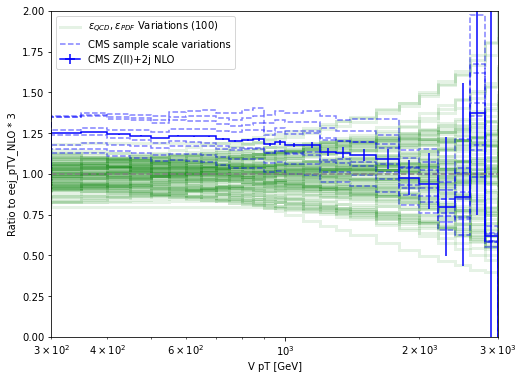

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

order = "NLO"
eej_qcd = make_lindert_pred("eej", order)
den = eej_qcd(np.zeros(113), ew=False) * 3
ax.axhline(1, color="grey", linestyle="--")

def scale(h, s):
    h = h.copy()
    h.view().value *= s
    h.view().variance *= s**2
    return h

reps = eej_qcd(np.random.normal(size=(100, 113)), ew=False) * 3 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, wpedges, color="g", alpha=0.1, linewidth=3, 
              label="$\epsilon_{QCD},\epsilon_{PDF}$ Variations (100)" if i==0 else None)

scale(cms_llj["Vpt"], 1 / den).plot1d(label="CMS Z(ll)+2j NLO", color="b")
# factor of 2: https://answers.launchpad.net/mg5amcnlo/+question/660414
scalevar = scale(cms_llj["Vptscale"], 2 / den)
for i in range(8):
    scalevar[i, :].plot1d(ax=ax, color="b", alpha=0.5, yerr=False, linestyle="--",
                            label="CMS sample scale variations" if i==0 else None
                           )

# ax.stairs(eej_qcd(fit.x) * 3 / den, wpedges, color="g", linewidth=3, label="Fit!")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.)
ax.set_ylabel(f"Ratio to eej_pTV_{order} * 3")
ax.set_xlabel("V pT [GeV]")
ax.legend(loc="upper left")
fig.savefig(f"ZPtFXFX_vs_lindert{order}.pdf")

In [28]:
def polyfit(h, deg, barycenter=0.5):
    x = h.axes[-1].edges[:-1] + np.diff(h.axes[-1].edges) * barycenter
    y = h.values()
    yerr = np.sqrt(h.variances())
    mask = (y > 0) & (yerr > 0)
    x, y, yerr = x[mask], y[mask], yerr[mask]
    return np.polyfit(np.log(x), y, deg, w=1/yerr)


def horner(v, xstr):
    if len(v) > 1:
        return f"({horner(v[:-1], xstr)})*{xstr} + {v[-1]}"
    return f"{v[0]}"

eval(horner([1, 2, 3], "log(x)"), {"log": np.log, "x": 3}) - np.polyval([1,2,3], np.log(3))

0.0

<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: divide by zero encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4
<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: invalid value encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4


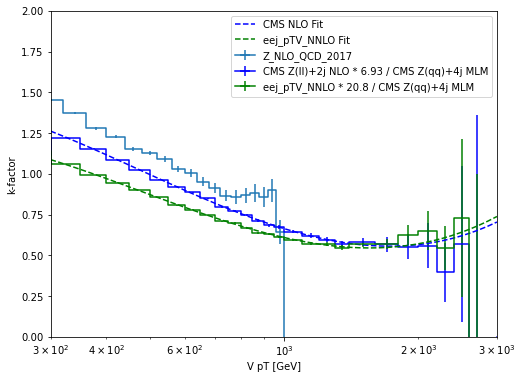

In [29]:
from correctionlib.schemav2 import CorrectionSet, Correction, Variable
from correctionlib.convert import from_histogram
import correctionlib

def evaluator(corr):
    cset = CorrectionSet(schema_version=2, corrections=[corr])
    return np.vectorize(
        correctionlib.CorrectionSet(cset)[corr.name].evaluate,
    )


vptvar = Variable(
    name="vpt",
    type="real",
    description="Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if virtual"
)

fig, ax = plt.subplots(figsize=(8, 6))

kfactors2["Z_NLO_QCD_2017"].to_hist().plot(ax=ax, label="Z_NLO_QCD_2017")


def ratio(num, den):
    val = num.view().value / den.view().value
    var = (
        num.view().variance / den.view().value**2
        + den.view().variance * num.view().value**2 / den.view().value**4
    )
    num = num.copy()
    num.view().value = val
    num.view().variance = var
    return num


x = np.geomspace(300, 3000)


tofxfx = ratio(
    scale(cms_llj["Vpt"], 6.93),
    cms_zqqj_mlm["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 3)
z_tofxfx_corr = Correction(
    name="Z_MLM2017toFXFX",
    version=1,
    description="k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM", color="b")
ax.plot(x, evaluator(z_tofxfx_corr)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(lindert["eej_pTV_NNLO"], 20.8),
    cms_zqqj_mlm["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 3)
z_tolindert_corr = Correction(
    name="Z_MLM2017toNNLOQCD",
    version=1,
    description="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM", color="g")
ax.plot(x, evaluator(z_tolindert_corr)(x), label="eej_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("Z_kCMS.pdf")

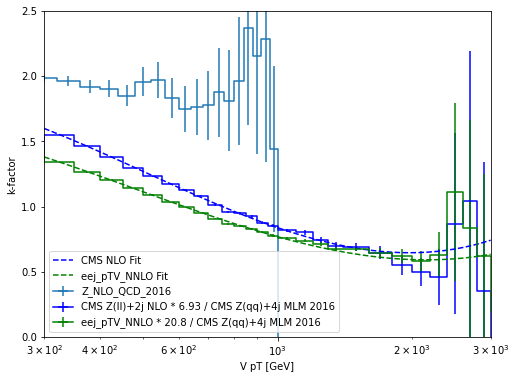

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

kfactors2["Z_NLO_QCD_2016"].to_hist().plot(ax=ax, label="Z_NLO_QCD_2016")

tofxfx = ratio(
    scale(cms_llj["Vpt"], 6.93),
    cms_zqqj_mlm16["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 3)
z_tofxfx_corr16 = Correction(
    name="Z_MLM2016toFXFX",
    version=1,
    description="k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM 2016", color="b")
ax.plot(x, evaluator(z_tofxfx_corr16)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(lindert["eej_pTV_NNLO"], 20.8),
    cms_zqqj_mlm16["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 3)
z_tolindert_corr16 = Correction(
    name="Z_MLM2016toNNLOQCD",
    version=1,
    description="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM 2016", color="g")
ax.plot(x, evaluator(z_tolindert_corr16)(x), label="eej_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2.5)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("Z_kCMS16.pdf")

In [31]:
edges = wpedges
den = lindert["eej_pTV_LO"].values() * lindert["eej_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(edges),
        "content": list(eej_qcd(epsilon) / den),
        "flow": "clamp",
    }


z_fixedorder_corr = Correction(
    name="Z_FixedOrderComponent",
    version=1,
    description="Z boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "Z_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "Z_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "Z_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "Z_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

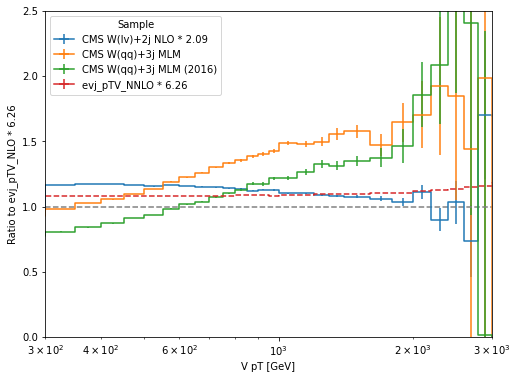

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

name = "Vpt"
den = lindert["evj_pTV_NLO"].values() * 6.26
ax.axhline(1, color="grey", linestyle="--")

scale(cms_lvj[name], 2.09 / den).plot1d(label="CMS W(lv)+2j NLO * 2.09")
scale(cms_wqqj_mlm[name], 1 / den).plot1d(label="CMS W(qq)+3j MLM")
scale(cms_wqqj_mlm16[name], 1 / den).plot1d(label="CMS W(qq)+3j MLM (2016)")
scale(lindert["evj_pTV_NNLO"], 6.26 / den).plot1d(linestyle="--", label="evj_pTV_NNLO * 6.26")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.5)
ax.set_ylabel("Ratio to evj_pTV_NLO * 6.26")
ax.set_xlabel("V pT [GeV]")
ax.legend(title="Sample", loc="upper left")
fig.savefig("WqqPt_vs_lindertNLO.pdf")

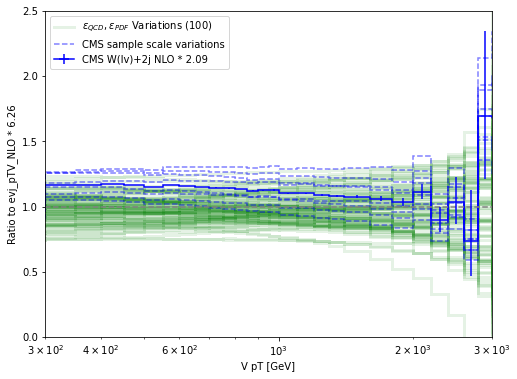

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

order = "NLO"
evj_qcd = make_lindert_pred("evj", order)
den = evj_qcd(np.zeros(113), ew=False) * 6.26
ax.axhline(1, color="grey", linestyle="--")

reps = evj_qcd(np.random.normal(size=(100, 113)), ew=False) * 6.26 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, wpedges, color="g", alpha=0.1, linewidth=3, 
              label="$\epsilon_{QCD},\epsilon_{PDF}$ Variations (100)" if i==0 else None)

scale(cms_lvj[name], 2.09 / den).plot1d(label="CMS W(lv)+2j NLO * 2.09", color="b")
# factor of 2: https://answers.launchpad.net/mg5amcnlo/+question/660414
scalevar = scale(cms_lvj["Vptscale"], 2*2.09 / den)
for i in range(8):
    scalevar[i, :].plot1d(ax=ax, color="b", alpha=0.5, yerr=False, linestyle="--",
                            label="CMS sample scale variations" if i==0 else None
                           )

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.5)
ax.set_ylabel(f"Ratio to evj_pTV_{order} * 6.26")
ax.set_xlabel("V pT [GeV]")
ax.legend(loc="upper left")
fig.savefig(f"WPtFXFX_vs_lindert{order}.pdf")

<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: divide by zero encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4
<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: invalid value encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4


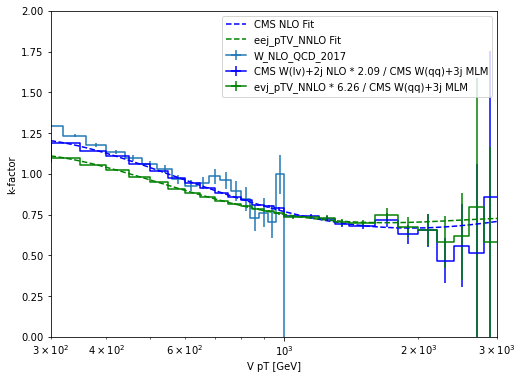

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

# evj["evj_pTV_K_NLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NLO")
# evj["evj_pTV_K_NNLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NNLO")

kfactors3["W_NLO_QCD_2017"].to_hist().plot(ax=ax, label="W_NLO_QCD_2017")

tofxfx = ratio(
    scale(cms_lvj["Vpt"], 2.09),
    cms_wqqj_mlm["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 4)
w_tofxfx_corr = Correction(
    name="W_MLM2017toFXFX",
    version=1,
    description="k_CMS(vpt), or CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM", color="b")
ax.plot(x, evaluator(w_tofxfx_corr)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(evj["evj_pTV_NNLO"], 6.26),
    cms_wqqj_mlm["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 4)
w_tolindert_corr = Correction(
    name="W_MLM2017toNNLOQCD",
    version=1,
    description="k_CMS(vpt), or evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM", color="g")
ax.plot(x, evaluator(w_tolindert_corr)(x), label="eej_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("W_kCMS.pdf")

<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: divide by zero encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4
<ipython-input-29-bbf776bda2da>:24: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
<ipython-input-29-bbf776bda2da>:26: RuntimeWarning: invalid value encountered in true_divide
  num.view().variance / den.view().value**2
<ipython-input-29-bbf776bda2da>:27: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4


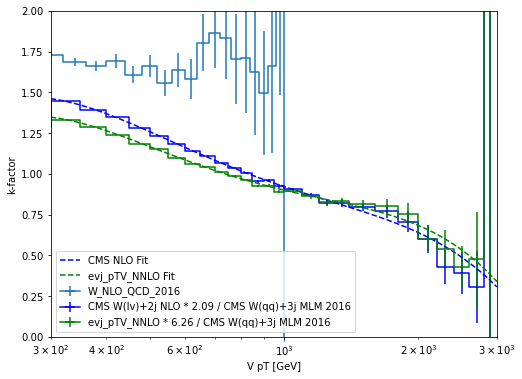

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# evj["evj_pTV_K_NLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NLO")
# evj["evj_pTV_K_NNLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NNLO")

kfactors3["W_NLO_QCD_2016"].to_hist().plot(ax=ax, label="W_NLO_QCD_2016")

tofxfx = ratio(
    scale(cms_lvj["Vpt"], 2.09),
    cms_wqqj_mlm16["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 4)
w_tofxfx_corr16 = Correction(
    name="W_MLM2016toFXFX",
    version=1,
    description="k_CMS(vpt), or CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM 2016",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM 2016", color="b")
ax.plot(x, evaluator(w_tofxfx_corr16)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(evj["evj_pTV_NNLO"], 6.26),
    cms_wqqj_mlm16["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 4)
w_tolindert_corr16 = Correction(
    name="W_MLM2016toNNLOQCD",
    version=1,
    description="k_CMS(vpt), or evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM 2016",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM 2016", color="g")
ax.plot(x, evaluator(w_tolindert_corr16)(x), label="evj_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("W_kCMS16.pdf")

In [36]:
edges = wpedges
den = lindert["evj_pTV_LO"].values() * lindert["evj_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(edges),
        "content": list(evj_qcd(epsilon) / den),
        "flow": "clamp",
    }


w_fixedorder_corr = Correction(
    name="W_FixedOrderComponent",
    version=1,
    description="W boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "W_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "W_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "W_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "W_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

In [37]:
cset = CorrectionSet(
    schema_version=2,
    corrections=[
        z_tofxfx_corr,
        z_tofxfx_corr16,
        z_tolindert_corr,
        z_tolindert_corr16,
        z_fixedorder_corr,
        w_tofxfx_corr,
        w_tofxfx_corr16,
        w_tolindert_corr,
        w_tolindert_corr16,
        w_fixedorder_corr,
    ]
)

import rich

rich.print(cset)
with open("vjets_corrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

📂 CorrectionSet (schema v2)                                                                 
├── 📈 Z_MLM2017toFXFX (v1)                                                                  
│   k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM                                
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [299.0, 3001.0), overflow ok                                                   │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_MLM2016toFXFX (v1)                                                                  
│   k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM                                
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [299.0, 3001.0), overflow ok                                                   │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_MLM2017toNNLOQCD (v1)                                                               
│   eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM                                                   
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [299.0, 3001.0), overflow ok                                                   │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_MLM2016toNNLOQCD (v1)                                                               
│   eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM                                                   
│   Node counts: Binning: 1, Formula: 1                  